In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.chdir('../')

In [3]:
from utils.config import Config
config_file = "configs/config_mistral.json"
cfg = Config.from_file(config_file)

In [4]:
import io

from models import VideoChat2_it_mistral
from utils.easydict import EasyDict
import torch

from transformers import StoppingCriteria, StoppingCriteriaList

from PIL import Image
import numpy as np
import numpy as np
from decord import VideoReader, cpu
import torchvision.transforms as T
from torchvision.transforms import PILToTensor
from torchvision import transforms
from dataset.video_transforms import (
    GroupNormalize, GroupScale, GroupCenterCrop, 
    Stack, ToTorchFormatTensor
)
from torch.utils.data import Dataset
from torchvision.transforms.functional import InterpolationMode

from torchvision import transforms

import matplotlib.pyplot as plt

from IPython.display import Video, HTML

from peft import get_peft_model, LoraConfig, TaskType
import copy

import json
from collections import OrderedDict

from tqdm import tqdm

import decord
decord.bridge.set_bridge("torch")

In [5]:
# load stage2 model
cfg.model.vision_encoder.num_frames = 4
model = VideoChat2_it_mistral(config=cfg.model)

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# add lora to run stage3 model
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, 
    r=16, lora_alpha=32, lora_dropout=0.,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
         "gate_proj", "up_proj", "down_proj", "lm_head"
    ]
)
model.mistral_model = get_peft_model(model.mistral_model, peft_config)

In [7]:
# state_dict = torch.load("/mnt/petrelfs/share_data/likunchang/model/videochat2/videochat2_mistral_7b_stage3.pth", "cpu")
# state_dict = torch.load("/mnt/petrelfs/share_data/likunchang/open_source/umt_mistral_7b_stage3_mistral2Dataset.pth", "cpu")
# state_dict = torch.load("/mnt/petrelfs/share_data/likunchang/open_source/umt_mistral_7b_stage3_data20240426_plus8.pth", "CPU")
state_dict = torch.load("/mnt/petrelfs/share_data/likunchang/open_source/umt_mistral_7b_stage3_mistral3Dataset.pth", "cpu")


if 'model' in state_dict.keys():
    msg = model.load_state_dict(state_dict['model'], strict=False)
else:
    msg = model.load_state_dict(state_dict, strict=False)
print(msg)

model = model.to(torch.device(cfg.device))
model = model.eval()

_IncompatibleKeys(missing_keys=['mistral_model.base_model.model.model.embed_tokens.weight', 'mistral_model.base_model.model.model.layers.0.self_attn.q_proj.weight', 'mistral_model.base_model.model.model.layers.0.self_attn.k_proj.weight', 'mistral_model.base_model.model.model.layers.0.self_attn.v_proj.weight', 'mistral_model.base_model.model.model.layers.0.self_attn.o_proj.weight', 'mistral_model.base_model.model.model.layers.0.mlp.gate_proj.weight', 'mistral_model.base_model.model.model.layers.0.mlp.up_proj.weight', 'mistral_model.base_model.model.model.layers.0.mlp.down_proj.weight', 'mistral_model.base_model.model.model.layers.0.input_layernorm.weight', 'mistral_model.base_model.model.model.layers.0.post_attention_layernorm.weight', 'mistral_model.base_model.model.model.layers.1.self_attn.q_proj.weight', 'mistral_model.base_model.model.model.layers.1.self_attn.k_proj.weight', 'mistral_model.base_model.model.model.layers.1.self_attn.v_proj.weight', 'mistral_model.base_model.model.mode

In [8]:
def get_prompt(conv):
    ret = conv.system + conv.sep
    for role, message in conv.messages:
        if message:
            ret += role + " " + message + " " + conv.sep
        else:
            ret += role
    return ret


def get_prompt2(conv):
    ret = conv.system + conv.sep
    count = 0
    for role, message in conv.messages:
        count += 1
        if count == len(conv.messages):
            ret += role + " " + message
        else:
            if message:
                ret += role + " " + message + " " + conv.sep
            else:
                ret += role
    return ret


def get_context_emb(conv, model, img_list, answer_prompt=None, print_res=False):
    if answer_prompt:
        prompt = get_prompt2(conv)
    else:
        prompt = get_prompt(conv)
    if print_res:
        print(prompt)
    if '<VideoHere>' in prompt:
        prompt_segs = prompt.split('<VideoHere>')
    else:
        prompt_segs = prompt.split('<ImageHere>')
    assert len(prompt_segs) == len(img_list) + 1, "Unmatched numbers of image placeholders and images."
    with torch.no_grad():
        seg_tokens = [
            model.mistral_tokenizer(
                seg, return_tensors="pt", add_special_tokens=i == 0).to("cuda:0").input_ids
            # only add bos to the first seg
            for i, seg in enumerate(prompt_segs)
        ]
        seg_embs = [model.mistral_model.base_model.model.model.embed_tokens(seg_t) for seg_t in seg_tokens]
#         seg_embs = [model.mistral_model.model.embed_tokens(seg_t) for seg_t in seg_tokens]
    mixed_embs = [emb for pair in zip(seg_embs[:-1], img_list) for emb in pair] + [seg_embs[-1]]
    mixed_embs = torch.cat(mixed_embs, dim=1)
    return mixed_embs


def ask(text, conv):
    conv.messages.append([conv.roles[0], text])
        

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops=[], encounters=1):
        super().__init__()
        self.stops = stops
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        for stop in self.stops:
            if torch.all((stop == input_ids[0][-len(stop):])).item():
                return True
        return False
    
    
def answer(conv, model, img_list, do_sample=True, max_new_tokens=200, num_beams=1, min_length=1, top_p=0.9,
               repetition_penalty=1.0, length_penalty=1, temperature=1.0, answer_prompt=None, print_res=False):
    stop_words_ids = [
        torch.tensor([2]).to("cuda:0"),
        torch.tensor([29871, 2]).to("cuda:0")]  # '</s>' can be encoded in two different ways.
    stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])
    
    conv.messages.append([conv.roles[1], answer_prompt])
    embs = get_context_emb(conv, model, img_list, answer_prompt=answer_prompt, print_res=print_res)
    with torch.no_grad():
        outputs = model.mistral_model.generate(
            inputs_embeds=embs,
            max_new_tokens=max_new_tokens,
            stopping_criteria=stopping_criteria,
            num_beams=num_beams,
            do_sample=do_sample,
            min_length=min_length,
            top_p=top_p,
            repetition_penalty=repetition_penalty,
            length_penalty=length_penalty,
            temperature=temperature,
        )
    output_token = outputs[0]
    if output_token[0] == 0:  # the model might output a unknow token <unk> at the beginning. remove it
            output_token = output_token[1:]
    if output_token[0] == 1:  # some users find that there is a start token <s> at the beginning. remove it
            output_token = output_token[1:]
    output_text = model.mistral_tokenizer.decode(output_token, add_special_tokens=False)
    output_text = output_text.split('</s>')[0]  # remove the stop sign </s>
#     output_text = output_text.split('[/INST]')[-1].strip()
    conv.messages[-1][1] = output_text + '</s>'
    return output_text, output_token.cpu().numpy()

In [9]:
def get_index(num_frames, num_segments):
    seg_size = float(num_frames - 1) / num_segments
    start = int(seg_size / 2)
    offsets = np.array([
        start + int(np.round(seg_size * idx)) for idx in range(num_segments)
    ])
    return offsets


def load_video(video_path, num_segments=8, return_msg=False, resolution=224):
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    num_frames = len(vr)
    frame_indices = get_index(num_frames, num_segments)

    # transform
    crop_size = resolution
    scale_size = resolution
    input_mean = [0.48145466, 0.4578275, 0.40821073]
    input_std = [0.26862954, 0.26130258, 0.27577711]

    transform = T.Compose([
        GroupScale(int(scale_size), interpolation=InterpolationMode.BICUBIC),
        GroupCenterCrop(crop_size),
        Stack(),
        ToTorchFormatTensor(),
        GroupNormalize(input_mean, input_std) 
    ])

    images_group = list()
    for frame_index in frame_indices:
        img = Image.fromarray(vr[frame_index].numpy())
        images_group.append(img)
    torch_imgs = transform(images_group)
    if return_msg:
        fps = float(vr.get_avg_fps())
        sec = ", ".join([str(round(f / fps, 1)) for f in frame_indices])
        # " " should be added in the start and end
        msg = f"The video contains {len(frame_indices)} frames sampled at {sec} seconds."
        return torch_imgs, msg
    else:
        return torch_imgs

In [10]:
def get_sinusoid_encoding_table(n_position=784, d_hid=1024, cur_frame=8, ckpt_num_frame=4, pre_n_position=784): 
    ''' Sinusoid position encoding table ''' 
    # TODO: make it with torch instead of numpy 
    def get_position_angle_vec(position): 
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)] 
    
    # generate checkpoint position embedding
    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(pre_n_position)]) 
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2]) # dim 2i 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2]) # dim 2i+1 
    sinusoid_table = torch.tensor(sinusoid_table, dtype=torch.float, requires_grad=False).unsqueeze(0)
    
    print(f"n_position: {n_position}")
    print(f"pre_n_position: {pre_n_position}")
    
    if n_position != pre_n_position:
        T = ckpt_num_frame # checkpoint frame
        P = 14 # checkpoint size
        C = d_hid
        new_P = int((n_position // cur_frame) ** 0.5) # testing size
        if new_P != 14:
            print(f'Pretraining uses 14x14, but current version is {new_P}x{new_P}')
            print(f'Interpolate the position embedding')
            sinusoid_table = sinusoid_table.reshape(-1, T, P, P, C)
            sinusoid_table = sinusoid_table.reshape(-1, P, P, C).permute(0, 3, 1, 2)
            sinusoid_table = torch.nn.functional.interpolate(
                sinusoid_table, size=(new_P, new_P), mode='bicubic', align_corners=False)
            # BT, C, H, W -> BT, H, W, C ->  B, T, H, W, C
            sinusoid_table = sinusoid_table.permute(0, 2, 3, 1).reshape(-1, T, new_P, new_P, C)
            sinusoid_table = sinusoid_table.flatten(1, 3)  # B, THW, C
    
    if cur_frame != ckpt_num_frame:
        print(f'Pretraining uses 4 frames, but current frame is {cur_frame}')
        print(f'Interpolate the position embedding')
        T = ckpt_num_frame # checkpoint frame
        new_T = cur_frame # testing frame
        # interpolate
        P = int((n_position // cur_frame) ** 0.5) # testing size
        C = d_hid
        sinusoid_table = sinusoid_table.reshape(-1, T, P, P, C)
        sinusoid_table = sinusoid_table.permute(0, 2, 3, 4, 1).reshape(-1, C, T)  # BHW, C, T
        sinusoid_table = torch.nn.functional.interpolate(sinusoid_table, size=new_T, mode='linear')
        sinusoid_table = sinusoid_table.reshape(1, P, P, C, new_T).permute(0, 4, 1, 2, 3) # B, T, H, W, C
        sinusoid_table = sinusoid_table.flatten(1, 3)  # B, THW, C
        
    return sinusoid_table

In [11]:
vid_path = "./demo/example/yoga.mp4"
# vid_path = "./demo/example/jesse_dance.mp4"


# num_frame = 8
num_frame = 16
# resolution = 384
resolution = 224
vid, msg = load_video(vid_path, num_segments=num_frame, return_msg=True, resolution=resolution)
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

print(msg)
    
# The model expects inputs of shape: T x C x H x W
TC, H, W = vid.shape
video = vid.reshape(1, TC//3, 3, H, W).to("cuda:0")

img_list = []
with torch.no_grad():
    image_emb, _ = model.encode_img(video, "Watch the video and answer the question.")
#     image_emb, _ = model.encode_img(video, "")

img_list.append(image_emb)

HTML(f'<video alt="test" controls><source src="{vid_path}" type="video/mp4"></video>')

n_position: 3136
pre_n_position: 784
Pretraining uses 4 frames, but current frame is 16
Interpolate the position embedding
The video contains 16 frames sampled at 0.3, 0.9, 1.5, 2.2, 2.8, 3.4, 4.0, 4.7, 5.3, 5.9, 6.5, 7.2, 7.8, 8.4, 9.0, 9.6 seconds.


/mnt/petrelfs/likunchang/.conda/envs/mistral/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [12]:
chat = EasyDict({
    "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

chat.messages.append([chat.roles[0], "<Video><VideoHere></Video> [/INST]"])
ask("Describe the video in details.", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=512, print_res=True)[0]
print(llm_message)

/mnt/petrelfs/likunchang/.conda/envs/mistral/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <Video><VideoHere></Video> [/INST] [INST] Describe the video in details. [/INST]
In the video, we see a woman performing yoga on a rooftop with a beautiful view of the mountains in the background. She is wearing a black tank top and grey yoga pants, and her hair is tied up in a ponytail. The woman starts by standing on her hands and then transitions into a downward dog position. She then moves into a plank position and holds it for a few seconds before transitioning back into downward dog. The woman then moves into a warrior pose, with her arms outstretched and her legs in a lunge position. She holds this pose for a few seconds before transitioning back into downward dog. Throughout the video, we can see the woman's focus and concentration as she performs each pose with precision and grace. The peaceful and serene environment of the rooftop adds to the overall ambiance of the video, making it a perfect setting for practicing yoga. 


In [13]:
chat = EasyDict({
    "system": "Describe the video in details.",
    # "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

chat.messages.append([chat.roles[0], "<Video><VideoHere></Video> [/INST]"])
ask("", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=512, print_res=True)[0]
print(llm_message)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Describe the video in details.[INST] <Video><VideoHere></Video> [/INST] [INST][/INST]
A woman is doing yoga on a rooftop. 


In [14]:
chat = EasyDict({
    "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

ask("<Video><VideoHere></Video> Describe the video in details.", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=512, print_res=True)[0]
print(llm_message)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <Video><VideoHere></Video> Describe the video in details. [/INST]
a woman is doing yoga on a rooftop 


n_position: 196
pre_n_position: 196


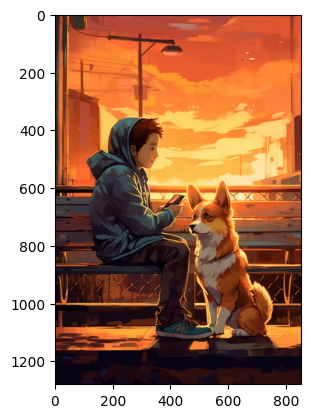

In [15]:
# img_path = "./demo/example/dog.png"
# img_path = "./demo/example/bear.jpg"
img_path = "./demo/example/people.jpg"
img = Image.open(img_path).convert('RGB')

plt.imshow(img)

resolution = 224
# resolution = 384
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2, cur_frame=1, ckpt_num_frame=1, pre_n_position=14*14)
model.vision_encoder.encoder.img_pos_embed = new_pos_emb

transform = transforms.Compose(
    [
        transforms.Resize(
            (resolution, resolution), interpolation=InterpolationMode.BICUBIC
        ),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]
)

img = transform(img).unsqueeze(0).unsqueeze(0).cuda()
img_list = []
with torch.no_grad():
#     image_emb, _ = model.encode_img(img, "")
    image_emb, _ = model.encode_img(img, "Observe the image and answer the question.")
img_list.append(image_emb)

In [16]:
chat = EasyDict({
    "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

chat.messages.append([chat.roles[0], f"<Image><ImageHere></Image> [/INST]"])
ask("Describe the following image in details.", chat)
# ask("Describe the following image in one sentence.", chat)
# ask("What is the text?", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=256, print_res=True,)[0]
print(llm_message)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <Image><ImageHere></Image> [/INST] [INST] Describe the following image in details. [/INST]
The image depicts a young boy sitting on a bench, petting a small dog. The boy is wearing a hoodie and appears to be enjoying the company of the dog. The scene takes place in a park, with a bench situated in the foreground and a few trees visible in the background. The sky is filled with a beautiful sunset, casting a warm, orange glow over the entire scene. The boy and the dog seem to be enjoying the peaceful atmosphere of the park, with the sunset providing a serene backdrop for their interaction. 


In [17]:
chat = EasyDict({
    "system": "Describe the following image in details. ",
    # "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

chat.messages.append([chat.roles[0], f"<Image><ImageHere></Image> [/INST]"])
ask("", chat)
# ask("Describe the following image in details. Pay attention to the potential text.", chat)
# ask("Describe the following image in one sentence.", chat)
# ask("What is the text?", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=256, print_res=True,)[0]
print(llm_message)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Describe the following image in details. [INST] <Image><ImageHere></Image> [/INST] [INST][/INST]
The image depicts a young boy sitting on a bench in a park, petting a small dog. The boy is wearing a hoodie and jeans, and the dog is sitting on the ground in front of him. The background of the image is a sunset, with the sun setting behind a row of buildings in the distance. The colors in the image are warm and muted, with the sun casting a golden glow over the scene. The overall mood of the image is peaceful and serene, with the boy and the dog enjoying each other's company in the quiet of the park. 


In [18]:
chat = EasyDict({
    "system": "",
    "roles": ("[INST]", "[/INST]"),
    "messages": [],
    "sep": ""
})

ask("<Image><ImageHere></Image> Describe the following image in details.", chat)
# ask("Describe the following image in one sentence.", chat)
# ask("What is the text?", chat)

llm_message = answer(conv=chat, model=model, do_sample=False, img_list=img_list, max_new_tokens=256, print_res=True,)[0]
print(llm_message)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] <Image><ImageHere></Image> Describe the following image in details. [/INST]
The image is a painting of a young boy sitting on a bench with a dog. The boy is wearing a hoodie and has a book in his hand. The dog is sitting in front of the boy, looking up at him. The background of the painting is a cityscape with tall buildings and a bridge. The sky is a beautiful orange color, indicating that it is either sunrise or sunset. 


In [19]:
data_list = {
    "Action Sequence": ("action_sequence.json", "p2:s3://star/Charades_v1_480/", "video", True), # has start & end
    "Action Prediction": ("action_prediction.json", "p2:s3://star/Charades_v1_480/", "video", True), # has start & end
    "Action Antonym": ("action_antonym.json", "p2:s3://ssv2_video/", "video", False),
    "Fine-grained Action": ("fine_grained_action.json", "p2hdd:s3://Moments_in_Time_Raw/videos/", "video", False),
    "Unexpected Action": ("unexpected_action.json", "p2:s3://FunQA_test/test/", "video", False),
    "Object Existence": ("object_existence.json", "p2:s3://clevrer/video_validation/", "video", False),
    "Object Interaction": ("object_interaction.json", "p2:s3://star/Charades_v1_480/", "video", True), # has start & end
    "Object Shuffle": ("object_shuffle.json", "p2:s3://perception/videos/", "video", False),
    "Moving Direction": ("moving_direction.json", "p2:s3://clevrer/video_validation/", "video", False),
    "Action Localization": ("action_localization.json", "p2:s3://sta/sta_video/", "video", True),  # has start & end
    "Scene Transition": ("scene_transition.json", "p2:s3://scene_qa/video/", "video", False),
    "Action Count": ("action_count.json", "p2:s3://perception/videos/", "video", False),
    "Moving Count": ("moving_count.json", "p2:s3://clevrer/video_validation/", "video", False),
    "Moving Attribute": ("moving_attribute.json", "p2:s3://clevrer/video_validation/", "video", False),
    "State Change": ("state_change.json", "p2:s3://perception/videos/", "video", False),
    "Fine-grained Pose": ("fine_grained_pose.json", "p2:s3://nturgbd/", "video", False),
    "Character Order": ("character_order.json", "p2:s3://perception/videos/", "video", False),
    "Egocentric Navigation": ("egocentric_navigation.json", "p2:s3://vlnqa/", "video", False),
    "Episodic Reasoning": ("episodic_reasoning.json", "p2:s3://tvqa/frames_fps3_hq/", "frame", True),  # has start & end, read frame
    "Counterfactual Inference": ("counterfactual_inference.json", "p2:s3://clevrer/video_validation/", "video", False),
}

data_dir = "/mnt/petrelfs/share_data/likunchang/mvbench/json"

In [20]:
from petrel_client.client import Client
from decord import VideoReader, cpu
client = Client('~/petreloss.conf', enable_mc=False)

In [ ]:
class MVBench_dataset(Dataset):
    def __init__(self, data_dir, data_list, num_segments=8, resolution=224):
        self.data_list = []
        for k, v in data_list.items():
            with open(os.path.join(data_dir, v[0]), 'r') as f:
                json_data = json.load(f)
            for data in json_data:
                self.data_list.append({
                    'task_type': k,
                    'prefix': v[1],
                    'data_type': v[2],
                    'bound': v[3],
                    'data': data
                })
        
        self.decord_method = {
            'video': self.read_video,
            'gif': self.read_gif,
            'frame': self.read_frame,
        }
        
        self.num_segments = num_segments
        
        # transform
        crop_size = resolution
        scale_size = resolution
        input_mean = [0.48145466, 0.4578275, 0.40821073]
        input_std = [0.26862954, 0.26130258, 0.27577711]
        self.transform = T.Compose([
            GroupScale(int(scale_size), interpolation=InterpolationMode.BICUBIC),
            GroupCenterCrop(crop_size),
            Stack(),
            ToTorchFormatTensor(),
            GroupNormalize(input_mean, input_std) 
        ])
    
    def __str__(self):
        len_list = {}
        option_list = {}
        for data in self.data_list:
            if data['task_type'] not in len_list:
                len_list[data['task_type']] = 0
            len_list[data['task_type']] += 1
            if data['task_type'] not in option_list:
                option_list[data['task_type']] = 0
            option_list[data['task_type']] += len(data['data']['candidates'])
        
        correct = 0
        total = 0
        res = f"There are {len(self.data_list)} videos as follow:\n"
        for k, v in len_list.items():
            correct += len_list[k]
            total += option_list[k]
            res += f"{v} for {k} ({option_list[k]} options => {len_list[k]/option_list[k]*100:.2f}%)\n"
            correct = correct + 1 / option_list[k]
        res += f"Total random accuracy: {correct/total*100:.2f}%"
        return res.rstrip()
        
    def __len__(self):
        return len(self.data_list)
    
    def get_index(self, bound, fps, max_frame, first_idx=0):
        if bound:
            start, end = bound[0], bound[1]
        else:
            start, end = -100000, 100000
        start_idx = max(first_idx, round(start * fps))
        end_idx = min(round(end * fps), max_frame)
        seg_size = float(end_idx - start_idx) / self.num_segments
        frame_indices = np.array([
            int(start_idx + (seg_size / 2) + np.round(seg_size * idx))
            for idx in range(self.num_segments)
        ])
        return frame_indices
    
    def read_video(self, video_path, bound=None):
        if "s3://" in video_path:
            video_bytes = client.get(video_path)
            vr = VideoReader(io.BytesIO(video_bytes), ctx=cpu(0), num_threads=1)
        else:
            vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
        max_frame = len(vr) - 1
        fps = float(vr.get_avg_fps())
        
        images_group = list()
        frame_indices = self.get_index(bound, fps, max_frame, first_idx=0) 
        for frame_index in frame_indices:
            img = Image.fromarray(vr[frame_index].numpy())
            images_group.append(img)
        torch_imgs = self.transform(images_group)
        return torch_imgs
    
    def read_gif(self, video_path, bound=None, fps=25):
        if "s3://" in video_path:
            video_bytes = client.get(video_path)
            gif = imageio.get_reader(io.BytesIO(video_bytes))
        else:
            gif = imageio.get_reader(video_path)
        max_frame = len(gif) - 1
        
        images_group = list()
        frame_indices = self.get_index(bound, fps, max_frame, first_idx=0) 
        for index, frame in enumerate(gif):
            if index in frame_indices:
                img = cv2.cvtColor(frame, cv2.COLOR_RGBA2RGB)
                img = Image.fromarray(img)
                images_group.append(img)
        torch_imgs = self.transform(images_group)
        return torch_imgs
    
    def read_frame(self, video_path, bound=None, fps=3):
        if os.path.exists(video_path):
            max_frame = len(os.listdir(video_path))
        else:
            max_frame = len([k for k in client.list(video_path)])
        images_group = list()
        frame_indices = self.get_index(bound, fps, max_frame, first_idx=1) # frame_idx starts from 1
        for frame_index in frame_indices:
            if "s3://" in video_path:
                img_bytes = client.get(os.path.join(video_path, f"{frame_index:05d}.jpg"))
                img = Image.open(io.BytesIO(img_bytes))
            else:
                img = Image.open(os.path.join(video_path, f"{frame_index:05d}.jpg"))
            images_group.append(img)
        torch_imgs = self.transform(images_group)
        return torch_imgs

    def qa_template(self, data):
        question = f"Question: {data['question']}\n"
        question += "Options:\n"
        answer = data['answer']
        answer_idx = -1
        for idx, c in enumerate(data['candidates']):
            question += f"({chr(ord('A') + idx)}) {c}\n"
            if c == answer:
                answer_idx = idx
        question = question.rstrip()
        answer = f"({chr(ord('A') + answer_idx)}) {answer}"
        return question, answer

    def __getitem__(self, idx):
        decord_method = self.decord_method[self.data_list[idx]['data_type']]
        bound = None
        if self.data_list[idx]['bound']:
            bound = (
                self.data_list[idx]['data']['start'],
                self.data_list[idx]['data']['end'],
            )
        video_path = os.path.join(self.data_list[idx]['prefix'], self.data_list[idx]['data']['video'])
        torch_imgs = decord_method(video_path, bound)
        question, answer = self.qa_template(self.data_list[idx]['data'])
            
        return {
            'video': torch_imgs, 
            'question': question, 
            'answer': answer,
            'task_type': self.data_list[idx]['task_type']
        }

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

dataset = MVBench_dataset(data_dir, data_list, num_segments=num_frame, resolution=resolution)

In [ ]:
def infer_mvbench(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False
    ):
    video = data_sample["video"]
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)
#     video_list.append(torch.zeros_like(video_emb))

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    if system_llm:
        prompt = system + data_sample['question'] + question_prompt
    else:
        prompt = data_sample['question'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f"GT: {data_sample['answer']}")
    return llm_message

In [ ]:
def check_ans(pred, gt):
    flag = False
    
    pred_list = pred.lower().split(' ')
    pred_option, pred_content = pred_list[0], ' '.join(pred_list[1:])
    gt_list = gt.lower().split(' ')
    gt_option, gt_content = gt_list[0], " ".join(gt_list[1:])
    if gt_content[-1] == '.':
        gt_content = gt_content[:-1]
    
    if pred_option.replace('.', '') in gt_option:
        flag = True
    elif gt_option in pred_option:
        flag = True
#     elif gt_content in pred_content:
#         flag = True
#     elif gt_content.replace("a ", "") in pred_content:
#         flag = True
#     elif gt_content.replace("an ", "") in pred_content:
#         flag = True
        
    return flag

In [ ]:
# save_path = "./demo/mvbench/umt_mistral_7b_notpe_nofvq_12m_stage3_mistral2Dataset_newit_system_textQ_20240204_lora16_newSystemPrompt2_questionPrompt3_addEnter_frame16"
# save_path = "./demo/mvbench/umt_mistral_7b_notpe_nofvq_12m_stage3_mistral2Dataset_newit_system_textQ_data20240426_plus8_lora16_newSystemPrompt2_questionPrompt3_addEnter_frame16"

correct = 0
total = 0
res_list = []
acc_dict = {}

for example in tqdm(dataset):
    task_type = example['task_type']
    if task_type not in acc_dict:
        acc_dict[task_type] = [0, 0] # correct, total
    acc_dict[task_type][1] += 1
    total += 1
    pred = infer_mvbench(
        example, 
#         "Carefully observe the video and choose the best option for the question. ", 
#         "Carefully watch the video and pay attention to the cause, sequence of events, and object details and movements. Based on your observations, select the best option that accurately addresses the question. ",  # newPrompt
#         "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question. ", # newPrompt2
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", # newPrompt2
#         question_prompt="\nOnly give the best option without any explanation.",
#         question_prompt="\nThink it step by step. Only give the best option without any explanation.", # prompt2
        question_prompt="\nOnly give the best option.",  # prompt3
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
#         system_q=True,
        print_res=True,
        system_llm=True
    )
    gt = example['answer']
    res_list.append({
        'pred': pred,
        'gt': gt
    })
    if check_ans(pred=pred, gt=gt):
        acc_dict[task_type][0] += 1
        correct += 1
    print(f"Part  Acc: {acc_dict[task_type][0] / acc_dict[task_type][1] * 100 :.2f}%")
    print(f"Total Acc: {correct / total * 100 :.2f}%")
    print('-' * 50, task_type, '-' * 50)

with open(f"{save_path}.json", "w") as f:
    json.dump({
        "acc_dict": acc_dict,
        "res_list": res_list
    }, f)

In [ ]:
final_res = dict()
correct = 0
total = 0
for k, v in acc_dict.items():
    final_res[k] = v[0] / v[1] * 100
    correct += v[0]
    total += v[1]    
final_res['Avg'] = correct / total * 100

print(final_res)

# with open("upload_leaderboard.json", "w") as f:
#     json.dump(final_res, f)

In [ ]:
# save_path = "./demo/mvbench/umt_mistral_7b_notpe_nofvq_12m_stage3_mistral2Dataset_newit_system_textQ_20240204_lora16_newSystemPrompt2_questionPrompt3_addEnter_frame16"
save_path = "./demo/mvbench/umt_mistral_7b_notpe_nofvq_12m_stage3_mistral2Dataset_newit_system_textQ_data20240426_plus8_lora16_newSystemPrompt2_questionPrompt3_addEnter_frame16"


out1 = "AS	AP	AA	FA	UA	OE	OI	OS	MD	AL	ST	AC	MC	MA	SC	FP	CO	EN	ER	CI	Avg"
out2 = ""
correct = 0
total = 0
with open(f"{save_path}.json", "r") as f:
    json_data = json.load(f)
    for k, v in json_data["acc_dict"].items():
        correct += v[0]
        total += v[1]    
        out2 += f"{v[0]/v[1]*100:.2f}\t"
out2 += f"{correct/total*100:.2f}"
print(out1)
print(out2)

In [ ]:
def check_answer_star(pred, qid):
    correct = 0
    answer_content = ans_dict[qid]['content'].lower()
    if answer_content[-1] == ".":
        answer_content = answer_content[:-1]
    if ans_dict[qid]['answer'].lower() in pred.lower():
        flag = True
        for kk in ["(A)", "(B)", "(C)", "(D)", "(E)"]:
            if kk != ans_dict[qid]['answer'].lower() and kk in pred.lower():
                flag = ans_dict
                break
        if flag:
            correct += 1
    elif answer_content in pred.lower():
        correct = 1
    elif answer_content.replace("a ", "") in pred.lower():
        correct = 1
    elif answer_content.replace("an ", "") in pred.lower():
        correct = 1
    return correct


def load_video_star(video_path, start, end, num_segments=8, return_msg=False, resolution=224):
    def _get_index(num_segments, start, end, fps, max_frame, first_idx=0):
        start_idx = max(first_idx, round(start * fps))
        end_idx = min(round(end * fps), max_frame)
        seg_size = float(end_idx - start_idx) / num_segments
        frame_indices = np.array([
            int(start_idx + (seg_size / 2) + np.round(seg_size * idx))
            for idx in range(num_segments)
        ])
        return frame_indices
    
    if "s3://" in video_path:
        video_bytes = client.get(video_path)
        vr = VideoReader(io.BytesIO(video_bytes), ctx=cpu(0), num_threads=1)
    else:
        vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    max_frame = len(vr) - 1
    fps = float(vr.get_avg_fps())
    
    frame_indices = _get_index(num_segments, start, end, fps, max_frame, first_idx=0) 

    # transform
    crop_size = 224
    scale_size = 224
    input_mean = [0.48145466, 0.4578275, 0.40821073]
    input_std = [0.26862954, 0.26130258, 0.27577711]

    transform = T.Compose([
        GroupScale(int(scale_size), interpolation=InterpolationMode.BICUBIC),
        GroupCenterCrop(crop_size),
        Stack(),
        ToTorchFormatTensor(),
        GroupNormalize(input_mean, input_std) 
    ])

    images_group = list()
    for frame_index in frame_indices:
        img = Image.fromarray(vr[frame_index].numpy())
        images_group.append(img)
    torch_imgs = transform(images_group)
    
    if return_msg:
        fps = float(vr.get_avg_fps())
        sec = ", ".join([str(round(f / fps, 1)) for f in frame_indices])
        # " " should be added in the start and end
        msg = f"The video contains {len(frame_indices)} frames sampled at {sec} seconds."
        return torch_imgs, msg
    else:
        return torch_imgs

def infer_star(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False,
        num_segments=8,
        format=""
    ):
    vid_path = os.path.join("p2:s3://star/Charades_v1_480/", data_sample['video'])
    video, _ = load_video_star(vid_path, start=data_sample['start'], end=data_sample['end'], num_segments=num_segments, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })
    if format == "0522":
        if system_llm:
            prompt = "<Video><VideoHere></Video> " + system + data_sample['QA'][0]['q'] + question_prompt
        else:
            prompt = "<Video><VideoHere></Video> " + data_sample['QA'][0]['q'] + question_prompt
    else:

        chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
        
        if system_llm:
            prompt = system + data_sample['QA'][0]['q'] + question_prompt
        else:
            prompt = data_sample['QA'][0]['q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f"GT: {data_sample['QA'][0]['a']}")
    return llm_message

In [21]:
#  position embedding
num_frame = 32
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

n_position: 6272
pre_n_position: 784
Pretraining uses 4 frames, but current frame is 32
Interpolate the position embedding


In [ ]:
json_data = json.load(open("/mnt/petrelfs/share_data/likunchang/star/val.json", "r"))
ans_data = json.load(open("/mnt/petrelfs/share_data/likunchang/star/val.json", "r"))
ans_dict = {}
for idx, data in enumerate(ans_data):
    ans = data['QA'][0]['a'].split(": ")[1].split(" ")[0].strip()
    content = data['QA'][0]['a'].split(ans)[1].strip()
    ans_dict[idx] = {
        'video': data['video'],
        'answer': ans,
        'content': content,
        'question': data['QA'][0]['q'].split('Options:')[0].strip(),
        'options': data['QA'][0]['q'].split('Options:')[1].strip()
    }

correct = 0
total = 0
total_num = len(json_data)

output = ""

for idx, example in enumerate(tqdm(json_data)):
    start = time.time()
    llm_message = infer_star(
        example, 
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", 
        question_prompt="\nOnly give the best option.", 
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
        print_res=False,
        system_llm=False,
        num_segments=32
    )
    
    duration = time.time() - start
    output += (example["video"] + '\n')
    output += (llm_message + '\n')
    correct += check_answer_star(llm_message, idx)
    total += 1
    print("Acc:", correct / total)
    print('-' * 20, f'{idx+1}/{total_num} done,', f'cost: {duration:.2f}s', '-' * 20)

In [ ]:
with open("./demo/star/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame32.txt", "w") as f:
    f.writelines(output)

In [ ]:
question_id = json.load(open("/mnt/petrelfs/share_data/likunchang/star/question_id.json", "r"))
acc_dict = dict()

with open("./demo/star/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame32.txt", "r") as f:
    lines = f.readlines()
    total = 0
    correct = 0
    while total * 2 < len(lines):
        llm_message = lines[total * 2 + 1].strip()
        correct += check_answer_star(llm_message, total)
        q_type = question_id[total].split('_')[0]
        if q_type not in acc_dict:
            acc_dict[q_type] = [0, 0]
        acc_dict[q_type][0] += check_answer_star(llm_message, total)
        acc_dict[q_type][1] += 1
        total += 1


for k, v in acc_dict.items():
    print(k, f"{v[0] / v[1] * 100:.2f}")
print("Total: ", f"{correct / total * 100:.2f}")

In [ ]:
with open("/mnt/petrelfs/share_data/likunchang/video_chatgpt/consistency_qa.json", "r") as f:
    c_data = json.load(f)
with open("/mnt/petrelfs/share_data/likunchang/video_chatgpt/generic_qa.json", "r") as f:
    g_data = json.load(f)
with open("/mnt/petrelfs/share_data/likunchang/video_chatgpt/temporal_qa.json", "r") as f:
    t_data = json.load(f)

path_dict = {} 
for path in client.list("p2:s3://video_chatgpt/Test_Videos/"):
    path_dict[path.split('.')[0]] = path

def infer_q(
        data_sample,
        path = "p2:s3://video_chatgpt/Test_Videos/",
        num_frame=16,
        system="", 
        question_prompt='', # add in the end of question
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True
    ):
    vid_path = path + path_dict[data_sample['video_name']]
    video, msg = load_video(vid_path, num_segments=num_frame, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    prompt = data_sample['Q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=None, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = llm_message.strip().split('\n')[0]
#     print(llm_message)
#     print(f"GT: {data_sample['A']}")
    return {
        'video': data_sample['video_name'],
        'Q': data_sample['Q'],
        'A': data_sample['A'],
        'pred': llm_message,
    }


def infer_q2(
        data_sample,
        path = "p2:s3://video_chatgpt/Test_Videos/",
        num_frame=16,
        system="", 
        question_prompt='', # add in the end of question
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True
    ):
    vid_path = path + path_dict[data_sample['video_name']]
    video, msg = load_video(vid_path, num_segments=num_frame, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })
    
    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    prompt = data_sample['Q1'] + question_prompt
    ask(prompt, chat)
    llm_message1 = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=None, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message1 = llm_message1.strip().split('\n')[0]
    
    chat = EasyDict({
        "system": system,
        "roles": ("Human", "Assistant"),
        "messages": [],
        "sep": "###"
    })
    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    prompt = data_sample['Q2'] + question_prompt
    ask(prompt, chat)
    llm_message2 = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=None, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message2 = llm_message2.strip().split('\n')[0]
    
#     print(llm_message1)
#     print(llm_message2)
#     print(f"GT: {data_sample['A']}")
    return {
        'video': data_sample['video_name'],
        'Q1': data_sample['Q1'],
        'Q2': data_sample['Q2'],
        'A': data_sample['A'],
        'pred1': llm_message1,
        'pred2': llm_message2,
    }

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb


save_path = "./demo/video_chatgpt/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16"


if not os.path.exists(save_path):
    os.mkdir(save_path)

g_res = []
g_path = "g_res_systemPrompt1_frame16.json"
file_path = os.path.join(save_path, g_path)
if not os.path.exists(file_path):
    for data_sample in tqdm(g_data):
        res = infer_q(
            data_sample,
            num_frame=16,
            system="Observe the video attentively and accurately respond to the associated question.\n", # prompt1
    #         system="Watch the video carefully, noticing the cause and sequence of events, and then answer the question.\n",  # prompt2
    #         system="Watch the video and answer the question.\n", # prompt3  
            question_prompt="",
            system_q=False,
            print_res=False
        )
        g_res.append(res)
    with open(file_path, "w") as f:
        json.dump(g_res, f)
else:
    print(f"File has already exists: {file_path}")
    

t_res = []
t_path = "t_res_systemPrompt1_frame16.json"
file_path = os.path.join(save_path, t_path)
if not os.path.exists(file_path):
    for data_sample in tqdm(t_data):
        res = infer_q(
            data_sample,
            num_frame=16,
            system="Observe the video attentively and accurately respond to the associated question.\n", # prompt1
    #         system="Watch the video carefully, noticing the cause and sequence of events, and then answer the question.\n",  # prompt2
    #         system="Watch the video and answer the question.\n", # prompt3  
            question_prompt="",
            system_q=False,
            print_res=False
        )
        t_res.append(res)
    with open(file_path, "w") as f:
        json.dump(t_res, f)
else:
    print(f"File has already exists: {file_path}")

    
c_res = []
c_path = "c_res_systemPrompt1_frame16.json"
file_path = os.path.join(save_path, c_path)
if not os.path.exists(file_path):
    for data_sample in tqdm(c_data):
        res = infer_q2(
            data_sample,
            num_frame=16,
            system="Observe the video attentively and accurately respond to the associated question.\n", # prompt1
    #         system="Watch the video carefully, noticing the cause and sequence of events, and then answer the question.\n",  # prompt2
    #         system="Watch the video and answer the question.\n", # prompt3  
            question_prompt="",
            system_q=False,
            print_res=False
        )
        c_res.append(res)
    with open(file_path, "w") as f:
        json.dump(c_res, f)
else:
    print(f"File has already exists: {file_path}")

In [ ]:
def load_video_tvqa(video_name, ts, frame_root='p2:s3://tvqa/frames_fps3_hq/' , num_segments=8, return_msg=False, resolution=224):
    def _get_index_by_time(start_sec, end_sec, num_segments=8, fps=3, max_frame=9999):
        start_idx = max(1, round(start_sec * fps))
        end_idx = min(round(end_sec * fps), max_frame)
        seg_size = float(end_idx - start_idx) / (num_segments - 1)
        offsets = np.array([start_idx + int(np.round(seg_size * idx)) for idx in range(num_segments)])
        return offsets
    
    start_sec , end_sec = ts.split('-')

    video_path = os.path.join(frame_root, video_name)
    if os.path.exists(video_path):
        max_frame = len(os.listdir(video_path))
    else:
        max_frame = len([k for k in client.list(video_path)])
    
    frame_indices = _get_index_by_time(float(start_sec), float(end_sec), num_segments=num_segments, max_frame=max_frame)

    # transform
    crop_size = 224
    scale_size = 224
    input_mean = [0.48145466, 0.4578275, 0.40821073]
    input_std = [0.26862954, 0.26130258, 0.27577711]

    transform = T.Compose([
        GroupScale(int(scale_size), interpolation=InterpolationMode.BICUBIC),
        GroupCenterCrop(crop_size),
        Stack(),
        ToTorchFormatTensor(),
        GroupNormalize(input_mean, input_std) 
    ])

    images_group = list()
    for frame_index in frame_indices:
        # img = Image.fromarray(vr[frame_index].asnumpy())
        img_bytes = client.get(os.path.join(frame_root, f"{video_name}/{frame_index:05d}.jpg"))
        img = Image.open(io.BytesIO(img_bytes))
        images_group.append(img)
    torch_imgs = transform(images_group)
    
    if return_msg:
        fps = float(vr.get_avg_fps())
        sec = ", ".join([str(round(f / fps, 1)) for f in frame_indices])
        # " " should be added in the start and end
        msg = f"The video contains {len(frame_indices)} frames sampled at {sec} seconds."
        return torch_imgs, msg
    else:
        return torch_imgs

def infer_tvqa(
        data_sample, system="", 
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        num_segments=8,
    ):
    video = load_video_tvqa(data_sample['vid_name'], data_sample['ts'], num_segments=num_segments)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)
#     video_list.append(torch.zeros_like(video_emb))

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    prompt = data_sample['msg']
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f'GT: a{data_sample["answer_idx"]}: {data_sample["a"]}')
    return llm_message


PATH = '/mnt/petrelfs/share_data/likunchang/tvqa'
with open(os.path.join(PATH, "val_msg0630_noSub.json"), "r") as f:
    video_list = json.load(f)

answer_dict = {}
for data in video_list:
    answer_dict[data['qid']] = {
        "question": f"{data['q']}",
        "answer": f"a{data['answer_idx']}",
        "options": ["a0: " + data["a0"], "a1: " + data["a1"], "a2: " + data["a2"], "a3: " + data["a3"], "a4: " + data["a4"]],
        "content": data["a"]
    }

def check_answer(pred, qid):
    correct = 0
    answer_content = answer_dict[qid]['content'].lower()
    if answer_content[-1] == ".":
        answer_content = answer_content[:-1]
    if answer_dict[qid]['answer'].lower() in pred.lower():
        flag = True
        for kk in ["a0", "a1", "a2", "a3", "a4"]:
            if kk != answer_dict[qid]['answer'].lower() and kk in pred.lower():
                flag = False
                break
        if flag:
            correct += 1
    elif answer_content in pred.lower():
        correct = 1
    elif answer_content.replace("a ", "") in pred.lower():
        correct = 1
    elif answer_content.replace("an ", "") in pred.lower():
        correct = 1
    return correct

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

correct = 0
total = 0
total_num = len(video_list)

output = ""
for idx, example in enumerate(tqdm(video_list)):
    start = time.time()
    try:
        llm_message = infer_tvqa(
            example, 
            "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", # newPrompt2
            answer_prompt="Best option:a",
            return_prompt='a',
            system_q=False,
            print_res=False,
            num_segments=16,
        )
        duration = time.time() - start
        output += (str(example["qid"]) + '\n')
        output += (llm_message + '\n')
    except Exception as e:
        output += (str(example["qid"]) + '\n')
        output += (str(e) + '\n')
        print(e)
    correct += check_answer(llm_message, example["qid"])
    total += 1
    print("Acc:", correct / total)
    print('-' * 20, f'{idx+1}/{total_num} done,', f'cost: {duration:.2f}s', '-' * 20)

In [ ]:
with open("./demo/tvqa/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "a") as f:
    f.writelines(output)

In [ ]:
def check_answer_nextqa(pred, qid):
    correct = 0
    answer_content = ans_dict[qid]['content'].lower()
    if answer_content[-1] == ".":
        answer_content = answer_content[:-1]
    if ans_dict[qid]['answer'].lower() in pred.lower():
        flag = True
        for kk in ["(A)", "(B)", "(C)", "(D)", "(E)"]:
            if kk != ans_dict[qid]['answer'].lower() and kk in pred.lower():
                flag = ans_dict
                break
        if flag:
            correct += 1
    elif answer_content in pred.lower():
        correct = 1
    elif answer_content.replace("a ", "") in pred.lower():
        correct = 1
    elif answer_content.replace("an ", "") in pred.lower():
        correct = 1
    return correct

def infer_nextqa(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False,
        num_segments=8,
    ):
    vid_path = os.path.join("p2:s3://nextqa", data_sample['video'])
    video, _ = load_video(vid_path, num_segments=num_segments, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)
#     video_list.append(torch.zeros_like(video_emb))

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    if system_llm:
        prompt = system + data_sample['QA'][0]['q'] + question_prompt
    else:
        prompt = data_sample['QA'][0]['q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f"GT: {data_sample['QA'][0]['a']}")
    return llm_message

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

json_data = json.load(open("/mnt/petrelfs/share_data/videointern/annotations/anno_instruction/videochat_new/video/reasoning/next_qa/val.json", "r"))
ans_data = json.load(open("/mnt/petrelfs/share_data/videointern/annotations/anno_instruction/videochat_new/video/reasoning/next_qa/val.json", "r"))
ans_dict = {}
for idx, data in enumerate(ans_data):
    ans = data['QA'][0]['a'].split(": ")[1].split(" ")[0].strip()
    content = data['QA'][0]['a'].split(ans)[1].strip()
    ans_dict[idx] = {
        'video': data['video'],
        'answer': ans,
        'content': content,
        'question': data['QA'][0]['q'].split('Options:')[0].strip(),
        'options': data['QA'][0]['q'].split('Options:')[1].strip()
    }

correct = 0
total = 0
total_num = len(json_data)

output = ""
for idx, example in enumerate(tqdm(json_data)):
    start = time.time()
    llm_message = infer_nextqa(
        example, 
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", 
        question_prompt="\nOnly give the best option.", 
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
        print_res=False,
        system_llm=False,
        num_segments=16
    )
    
    duration = time.time() - start
    output += (example["video"] + '\n')
    output += (llm_message + '\n')
    correct += check_answer_nextqa(llm_message, idx)
    total += 1
    print("Acc:", correct / total)
    print('-' * 20, f'{idx+1}/{total_num} done,', f'cost: {duration:.2f}s', '-' * 20)

In [ ]:
with open("./demo/nextqa/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "a") as f:
    f.writelines(output)

In [ ]:
type_dict = {}

with open("/mnt/petrelfs/share_data/likunchang/nextqa/val.csv", "r") as f:
    lines = f.readlines()
    for line in lines[1:]:
        msg = line.split(',')
        type_dict[msg[0]] = msg[7]

acc_dict = dict()

with open("./demo/nextqa/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "r") as f:
    lines = f.readlines()
    total = 0
    correct = 0
    while total * 2 < len(lines):
        video_id = lines[total * 2].strip().split('/')[1].split('.')[0]
        llm_message = lines[total * 2 + 1].strip()
        correct += check_answer_nextqa(llm_message, total)
        q_type = type_dict[video_id]
        if q_type not in acc_dict:
            acc_dict[q_type] = [0, 0]
        acc_dict[q_type][0] += check_answer_nextqa(llm_message, total)
        acc_dict[q_type][1] += 1
        total += 1

for k, v in acc_dict.items():
    print(k, f"{v[0] / v[1] * 100:.2f}")

acc_dict2 = dict()
for k, v in acc_dict.items():
    tmp = k[0]
    if tmp not in acc_dict2:
        acc_dict2[tmp] = [0, 0]
    acc_dict2[tmp][0] += v[0]
    acc_dict2[tmp][1] += v[1]
for k, v in acc_dict2.items():
    print(k, f"{v[0] / v[1] * 100:.2f}")

print(correct / total * 100)

In [ ]:
def check_answer_egoschema(pred, qid):
    correct = 0
    answer_content = ans_dict[qid]['content'].lower()
    if answer_content[-1] == ".":
        answer_content = answer_content[:-1]
    if ans_dict[qid]['answer'].lower() in pred.lower():
        flag = True
        for kk in ["(A)", "(B)", "(C)", "(D)", "(E)"]:
            if kk != ans_dict[qid]['answer'].lower() and kk in pred.lower():
                flag = ans_dict
                break
        if flag:
            correct += 1
    elif answer_content in pred.lower():
        correct = 1
    elif answer_content.replace("a ", "") in pred.lower():
        correct = 1
    elif answer_content.replace("an ", "") in pred.lower():
        correct = 1
    return correct

def infer_egoschema(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False,
        num_segments=8,
    ):
    vid_path = os.path.join("shdd:s3://egoschema/videos", data_sample['video'])
    print(vid_path)
    video, _ = load_video(vid_path, num_segments=num_segments, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)
#     video_list.append(torch.zeros_like(video_emb))

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    if system_llm:
        prompt = system + data_sample['QA'][0]['q'] + question_prompt
    else:
        prompt = data_sample['QA'][0]['q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f"GT: {data_sample['QA'][0]['a']}")
    return llm_message

In [ ]:
import csv
with open("/mnt/petrelfs/likunchang/code/learn/IG-VLM/data/multiple_choice_qa/EgoSchema.csv", mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)

    json_data = []
    ans_dict = {}
    
    for idx, msg in enumerate(reader):
        if idx == 0:
            print(msg)
            continue
            
        video = msg[1] + '.mp4'
        input_str = f"Question: {msg[3].capitalize()}\nOptions:\n"
    
        target_index = -1
        for i, candidate in enumerate(msg[5:]):
            option = chr(ord('A') + i)
            input_str += f"({option}) {candidate}\n"
            if candidate == msg[4]:
                target_index = i
            
        assert target_index != -1
        correct = chr(ord('A') + target_index)
        
        json_data.append({
            'video': video,
            "QA": [{
                "i": "",
                "q": input_str.strip(),
                "a": f"Answer: ({correct}) {msg[4]}",
            }]
        })

        ans_dict[idx - 1] = {
            'video': video,
            'answer': f"({correct})",
            'content': msg[4],
        }

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

correct = 0
total = 0
total_num = len(json_data)

output = ""

for idx, example in enumerate(tqdm(json_data)):
    start = time.time()
    llm_message = infer_egoschema(
        example, 
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", 
        question_prompt="\nOnly give the best option.", 
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
        print_res=False,
        system_llm=False,
        num_segments=16
    )
    
    duration = time.time() - start
    output += (example["video"] + '\n')
    output += (llm_message + '\n')
    correct += check_answer_egoschema(llm_message, idx)
    total += 1
    print("Acc:", correct / total)
    print('-' * 20, f'{idx+1}/{total_num} done,', f'cost: {duration:.2f}s', '-' * 20)

In [ ]:
with open("./demo/egoschema/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "a") as f:
    f.writelines(output)

In [ ]:
with open("/mnt/petrelfs/share_data/xujilan/EgoSchema/questions.json", "r") as f:
    full_data = json.load(f)

full_egoschema = []
for data in full_data:
    video = data['q_uid'] + '.mp4'
    input_str = f"Question: {data['question'].capitalize()}\nOptions:\n"

    for i, candidate in enumerate(['option 0', 'option 1', 'option 2', 'option 3', 'option 4']):
        option = chr(ord('A') + i)
        input_str += f"({option}) {data[candidate]}\n"
    
    full_egoschema.append({
        'q_uid': data['q_uid'],
        'video': video,
        "QA": [{
            "i": "",
            "q": input_str.strip(),
            "a": "",
        }]
    })


def infer_full_egoschema(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False,
        num_segments=8,
    ):
    vid_path = os.path.join("shdd:s3://egoschema/videos", data_sample['video'])
    print(vid_path)
    video, _ = load_video(vid_path, num_segments=num_segments, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    if system_llm:
        prompt = system + data_sample['QA'][0]['q'] + question_prompt
    else:
        prompt = data_sample['QA'][0]['q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    return llm_message


#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb


ans_dict = {}

for idx, example in enumerate(tqdm(full_egoschema)):
    start = time.time()
    llm_message = infer_full_egoschema(
        example, 
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", 
        question_prompt="\nOnly give the best option.", 
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
        print_res=False,
        system_llm=False,
        num_segments=16,
    )

    assert llm_message[0] == '(' and llm_message[2] == ')'
    ans = ord(llm_message[1]) - ord('A')
    assert ans in [0, 1, 2, 3, 4]
    ans_dict[example['q_uid']] = ans

In [ ]:
def check_answer_intentqa(pred, qid):
    correct = 0
    answer_content = ans_dict[qid]['content'].lower()
    if answer_content[-1] == ".":
        answer_content = answer_content[:-1]
    if ans_dict[qid]['answer'].lower() in pred.lower():
        flag = True
        for kk in ["(A)", "(B)", "(C)", "(D)", "(E)"]:
            if kk != ans_dict[qid]['answer'].lower() and kk in pred.lower():
                flag = ans_dict
                break
        if flag:
            correct += 1
    elif answer_content in pred.lower():
        correct = 1
    elif answer_content.replace("a ", "") in pred.lower():
        correct = 1
    elif answer_content.replace("an ", "") in pred.lower():
        correct = 1
    return correct

def infer_intentqa(
        data_sample, system="", 
        question_prompt='', # add in the end of question
        answer_prompt=None, # add in the begining of answer
        return_prompt='',  # add in the begining of return message
        system_q=False, # whether add question in the system prompt for QFormer
        print_res=True,
        system_llm=False,
        num_segments=8,
    ):
    vid_path = os.path.join("p2:s3://IntentQA/videos", data_sample['video'])
    print(vid_path)
    video, _ = load_video(vid_path, num_segments=num_segments, return_msg=True)
    TC, H, W = video.shape
    video = video.reshape(1, TC//3, 3, H, W).to("cuda:0")
    
    video_list = []
    with torch.no_grad():
        if system_q:
            video_emb, _ = model.encode_img(video, system + data_sample['question'])
        else:
            video_emb, _ = model.encode_img(video, system)
    video_list.append(video_emb)
#     video_list.append(torch.zeros_like(video_emb))

    chat = EasyDict({
        "system": system,
        "roles": ("[INST]", "[/INST]"),
        "messages": [],
        "sep": ""
    })

    chat.messages.append([chat.roles[0], f"<Video><VideoHere></Video> [/INST]"])
    
    if system_llm:
        prompt = system + data_sample['QA'][0]['q'] + question_prompt
    else:
        prompt = data_sample['QA'][0]['q'] + question_prompt
    
    ask(prompt, chat)

    llm_message = answer(
        conv=chat, model=model, do_sample=False, 
        img_list=video_list, max_new_tokens=100, 
        answer_prompt=answer_prompt, print_res=print_res
    )[0]
    # remove potential explanation
    llm_message = return_prompt + llm_message.strip().split('\n')[0]
    print(llm_message)
    print(f"GT: {data_sample['QA'][0]['a']}")
    return llm_message

In [ ]:
import csv
# with open("/mnt/petrelfs/share_data/likunchang/IntentQA/val.csv", mode='r', encoding='utf-8') as file:
with open("/mnt/petrelfs/share_data/likunchang/IntentQA/test.csv", mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)

    json_data = []
    ans_dict = {}
    
    for idx, msg in enumerate(reader):
        if idx == 0:
            print(msg)
            continue
            
        video = msg[0] + '.mp4'
        input_str = f"Question: {msg[4].capitalize()}\nOptions:\n"
    
        target_index = -1
        for i, candidate in enumerate(msg[8:13]):
            option = chr(ord('A') + i)
            input_str += f"({option}) {candidate}\n"

        target_index = int(msg[5])
        correct = chr(ord('A') + target_index)
        content = msg[8 + target_index]
        
        json_data.append({
            'video': video,
            "QA": [{
                "i": "",
                "q": input_str.strip(),
                "a": f"Answer: ({correct}) {content}",
            }]
        })

        ans_dict[idx - 1] = {
            'video': video,
            'answer': f"({correct})",
            'content': content,
        }

In [ ]:
#  position embedding
num_frame = 16
resolution = 224
new_pos_emb = get_sinusoid_encoding_table(n_position=(resolution//16)**2*num_frame, cur_frame=num_frame)
model.vision_encoder.encoder.pos_embed = new_pos_emb

correct = 0
total = 0
total_num = len(json_data)

output = ""

for idx, example in enumerate(tqdm(json_data)):
    start = time.time()
    llm_message = infer_intentqa(
        example, 
        "Carefully watch the video and pay attention to the cause and sequence of events, the detail and movement of objects, and the action and pose of persons. Based on your observations, select the best option that accurately addresses the question.\n", 
        question_prompt="\nOnly give the best option.", 
        answer_prompt="Best option:(",
        return_prompt='(',
        system_q=False,
        print_res=False,
        system_llm=False,
        num_segments=16,
    )
    
    duration = time.time() - start
    output += (example["video"] + '\n')
    output += (llm_message + '\n')
    correct += check_answer_intentqa(llm_message, idx)
    total += 1
    print("Acc:", correct / total)
    print('-' * 20, f'{idx+1}/{total_num} done,', f'cost: {duration:.2f}s', '-' * 20)

In [ ]:
# with open("./demo/intentqa/val/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "a") as f:
with open("./demo/intentqa/test/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "a") as f:
    f.writelines(output)

In [ ]:
type_dict = {}

# with open("/mnt/petrelfs/share_data/likunchang/IntentQA/val.csv", mode='r', encoding='utf-8') as file:
with open("/mnt/petrelfs/share_data/likunchang/IntentQA/test.csv", mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)
    for idx, msg in enumerate(reader):
        if idx == 0:
            continue
        type_dict[idx - 1] = msg[7]

acc_dict = dict()

# with open("./demo/intentqa/val/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "r") as f:
with open("./demo/intentqa/test/umt_mistral_7b_notpe_nofvq_12m_stage2_newit_system_textQ_20240204_lora16_stage3_frame16.txt", "r") as f:
    lines = f.readlines()
    total = 0
    correct = 0
    while total * 2 < len(lines):
        llm_message = lines[total * 2 + 1].strip()
        correct += check_answer_intentqa(llm_message, total)
        q_type = type_dict[total]
        if q_type not in acc_dict:
            acc_dict[q_type] = [0, 0]
        acc_dict[q_type][0] += check_answer_intentqa(llm_message, total)
        acc_dict[q_type][1] += 1
        total += 1


for k, v in acc_dict.items():
    print(k, f"{v[0] / v[1] * 100:.2f}")

print("TN&TP:", (acc_dict['TN'][0] + acc_dict['TP'][0]) / (acc_dict['TN'][1] + acc_dict['TP'][1]) * 100)

print(correct / total * 100)